# Lecture 8: Neural Networks

In this lecture, we'll be looking at various kinds of neural networks.  Neural networks in python are a very quickly evolving area, and there are many different competing packages for working with them.  Unfortunately, there's not yet a standard set of packages in scikit-learn like we've seen for many other machine learning methods.  

Most of the packages are high level wrappers around [Theano](http://deeplearning.net/software/theano/), which is a mathematical package for easily working with numerical expressions of arrays and matrices and their gradients.  Additionally, Theano code will also run seamlessly on a GPU if one is available.  This makes training much, much faster.  Here's an [ipython notebook](http://nbviewer.ipython.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb) on Theano if you're interested. 

[Keras](https://github.com/fchollet/keras/) is a relatively new package.  It looks to be a good balance between sophistication and simplicity.  Installation instructions are at that link.

[Lasagne](http://lasagne.readthedocs.org/en/latest/) is another, more full-featured, package, but we won't have time to go into it.

In [1]:
%matplotlib inline

In [2]:
import gzip
import os
import sys
import time
import numpy as np
import pandas as pd

# pickle lets us save python objects to a file and read them back in
import pickle
import itertools

# here are our neural network imports
#from sknn import mlp

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

import theano

import urllib.request
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
# scikit-learn does have a restricted boltzman machine class for doing unsupervised
# feature learning
from sklearn.neural_network import BernoulliRBM

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's see where Theano will run our code:

In [3]:
print(theano.config.device)

cpu


If we had a GPU, we could use it by setting `theano.config.device='gpu'`.

## Multilayer Perceptron with a Single Hidden Layer

We'll be working with the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits.  Note that this is a much bigger, higher resolution dataset than the handwritten digits dataset that we've seein in previous lectures.  In this first example, we'll use scikit-neuralnetwork and then Lasagne.  The following code is a modified version based off of the Lasagne MNIST example [here](https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py).

First, we'll download the MNIST dataset as a pickle file, save it to a local file, and then read in its contents.  If we've already downloaded the file, we'll just read it in.

In [15]:
DATA_URL = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
DATA_FILENAME = 'mnist.pkl.gz'

if not os.path.exists(DATA_FILENAME):
    print("Downloading MNIST dataset...")
    urllib.request.urlretrieve(DATA_URL, DATA_FILENAME)

with gzip.open(DATA_FILENAME, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

The pickle object has a training set, a validation set, and a test set.  Let's split those out and make a dictionary of things to pass to Theano/Lasagne:

In [16]:
X_train, y_train = data[0]
X_valid, y_valid = data[1]
X_test, y_test = data[2]

The images of handwritten digits are 28 by 28 pixels (28*28=784):

In [23]:
X_train.shape

(50000, 784)

In [24]:
X_train[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

The previous handwritten digits dataset that we worked with was only 8 by 8 pixels.  Let's define a function so that we can look at some of the images:

In [25]:
def plot_handwritten_digit(the_image, label):
    plt.axis('off')
    plt.imshow(the_image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

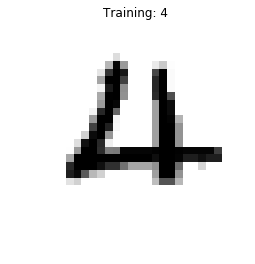

In [26]:
image_num = 1220
plot_handwritten_digit(X_train[image_num].reshape((28, 28)), y_train[image_num])

Here, we define some constants that will be used in the training:

In [29]:
# we'll feed in this many training examples at a time
#BATCH_SIZE = 600

# this is how many times we'll go through the set of batches, i.e. a full pass over
# all of the training data
#NUM_EPOCHS = 10

# number of units in the hidden layer
#NUM_HIDDEN_UNITS = 512

# these parameters control the gradient descent process to learn the weights
#LEARNING_RATE = 0.01
#MOMENTUM = 0.9 


# number of units in a single hidden layer
NUM_HIDDEN_UNITS = 512

# these parameters control the gradient descent process to learn the weights
LEARNING_RATE = 0.01
MOMENTUM = 0.9 

# we'll feed in this many training examples at a time (for stochastic gradient descent)
BATCH_SIZE = 600

# this is how many times we'll go through the set of batches, i.e. a full pass over
# all of the training data
NUM_EPOCHS = 10

### `keras`

Keras is quite popular.  Interestingly, it does not actually do computations -it provides a relatively easy to use syntax for setting up and training neural networks that can be combined with a computational backend (theano, tensorflow).  This makes it very convenient since the keras code you write when using a theano backend is the same as the code you'd write if you were using tensorflow as a backend.  Swapping between theano and tensorflow on the backend requires a simple change to the keras configuration file (should be located in the ```.keras``` folder in your root directory, and called ```keras.json```; see https://keras.io/backend/).

For a list of keras commands, and references on what each does, see: https://keras.io/layers/core/.

Thes examples are based on the example found at: 
https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
Be careful with keras examples -you have to go to the actual Github
respository to get examples that are consistent with the latest version
of the package, otherwise everything breaks...

First, we setup the model.  This model is again simple - one layer for inputs, one hidden layer, and then one layer for outputs.  We will use sigmoid activation for the hidden layer, and softmax activation for the output layer.  This setup lets us perform classification -by taking the largest value in the softmax layer across the ten possible outputs (0, 1, ..., 9), we can classify new observations.  We will also measure our network's performance on the test set.

In [30]:
# Tell keras we want to create a sequential (feed-forward network) model, in which one
# layer follows the next
model = Sequential()

# Create the input layer and the hidden layer of the network
# 'Dense' indicates that we want all inputs to connect to every node in the hidden layer
# 'input_shape' tells the hidden layer the dimension of the input to expect, which is determined
#    by our data (the number of predictors in our data set = 784 pixels per image)
# 'NUM_HIDDEN_UNITS' (which we defined above) tells keras how many nodes are the hidden layer connected
#    to the input layer
# 'activation' specifies how values from the input node should be processed by hidden nodes.
model.add(Dense(NUM_HIDDEN_UNITS, input_shape=(784,), activation='sigmoid', init='uniform'))

# Next, we'll create an output layer.
# The value '10' tells keras we want this layer to have ten nodes
# The 'activation' tells keras we want to use the softmax function
# Note that we don't specify 'input_shape'.  The input to this layer is the output of the hidden
# layer we created above. keras is smart enough to figure this out, which is why we only need
# to specify how many nodes are in the output layer.
model.add(Dense(10, activation='softmax', init='uniform'))

# Next, we specify the properties of our optimizer.
# We'll be using stochastic gradient descent with momentum, along with 
# the crossentropy cost function.
# Note: The 'decay' argument was not discussed in lecture - it reduces the learning
# rate as we get further into training (e.g., as we go from one epoch to the next)
# The benefit of decay is that the optimizer will make bigger adjustments
# early on, then do fine-tuning later in the training process.
sgd = SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Summarize the model setup
model.summary()

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_shape=(784,), activation="sigmoid", kernel_initializer="uniform")`
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Then we fit it:

In [32]:
# The np_utils module is part of keras, and has functioan designed to make it easier to work with neural networks.
# Here, we're using it to convert the label response data into vectors.
Y_train = np_utils.to_categorical(y_train, 10)
Y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

Third, let's fit the model.  We pass it the training data, the batch_size (for SGD), and the number of epochs.  Notice the ```.fit``` syntax, which is the same syntax used for all scikit-learn models we've used thusfar

In [33]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS)

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/10
50000/50000 [==============================] - 2s - loss: 2.1062     - 
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 1.5146     
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 1.0126     
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 0.7620     
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 0.6341     
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 0.5590     
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 0.5094     
Epoch 8/10
50000/50000 [==============================] - 1s - loss: 0.4743     
Epoch 9/10
50000/50000 [==============================] - 1s - loss: 0.4486     
Epoch 10/10
50000/50000 [==============================] - 1s - loss: 0.4287     


Next, we'll predict on the test set using the neural network.  Since we had ten output nodes, keras will give us a 10-dimensional vector for each test observation.  Each entry in the vector can be interpreted as the probability that the test vector's label corresponds to the entry (e.g., first entry is the probability that the test observation is a `0`).

In [35]:
Y_test_keras = model.predict(X_test)
Y_test_keras

array([[  2.59895867e-04,   1.18811486e-05,   8.88102368e-05, ...,
          9.92178679e-01,   5.46572410e-05,   5.80947334e-03],
       [  2.92448252e-02,   1.58728613e-03,   7.18269765e-01, ...,
          4.67639120e-06,   1.83281917e-02,   1.12579255e-05],
       [  1.00773352e-04,   9.53497231e-01,   1.24950185e-02, ...,
          8.23997520e-03,   4.70800139e-03,   1.82167382e-03],
       ..., 
       [  1.85203480e-05,   1.08833941e-04,   1.36234841e-04, ...,
          6.08499488e-03,   2.77231671e-02,   1.69013709e-01],
       [  1.63515657e-02,   1.52351148e-02,   6.58736192e-03, ...,
          4.94785141e-03,   2.95459598e-01,   6.85393857e-03],
       [  3.51337646e-03,   2.18260254e-07,   3.75234382e-03, ...,
          1.80005571e-07,   5.54580001e-05,   7.12992778e-06]], dtype=float32)

In [41]:
# We can also call predict_classes on the model to get the predicted labels directly, rather than probability vectors
test_preds = model.predict_classes(X_test)
test_preds

 8640/10000 [========================>.....] - ETA: 0s

array([7, 2, 1, ..., 4, 5, 6])

Finally, we measure the accuracy of the neural network.  Recall that precision is the fraction of observations labeled as a class that actually are of that class, and recall is the fraction of observations from a class that were labeled correctly.

In [42]:
print(classification_report(y_test, test_preds))
print(accuracy_score(y_test, test_preds))

             precision    recall  f1-score   support

          0       0.92      0.97      0.95       980
          1       0.93      0.97      0.95      1135
          2       0.90      0.85      0.87      1032
          3       0.85      0.90      0.87      1010
          4       0.84      0.94      0.89       982
          5       0.88      0.79      0.83       892
          6       0.91      0.91      0.91       958
          7       0.89      0.90      0.90      1028
          8       0.87      0.83      0.85       974
          9       0.90      0.84      0.87      1009

avg / total       0.89      0.89      0.89     10000

0.8919


If we want to visualize what the hidden nodes are picking up on, we can extract the weights for a single hidden node, then pass those weights into the function we created earlier to plot digits.  This works because there is one weight per pixel, so the number of weights for a node can be rehaped into an 'image'.  When a pixel has a large weight, it will be darker in the image, and when a pixel has a low weight, it will lighter in the image.

In [43]:
# We can extract the weights from the hidden layer using the get_weights
# function provided by keras.
len(model.get_weights())

4

This tell us that keras is tracking four sets of 'weights'. The first set of weights, model.get_weights()[0] corresponds to the weights used when mapping the inputs to the first hidden layer. The second set of weights, model.get_weights()[1], actually corresponds to the bias terms to the first hidden layers. The second two entries, indexed by 2 and 3 are the weights and biases applid to the hidden layer when mapping to the output layer.

In [44]:
model.get_weights()[0].shape

(784, 512)

We see that the first set of weights is stored in an array with one row per pixel (i.e., one row per input node in our network), and one column per hidden node.  Therefore, if we want to see what pattern the a hidden node is detecting, we pass the corresponding weight column to the digit plot function we created earlier.

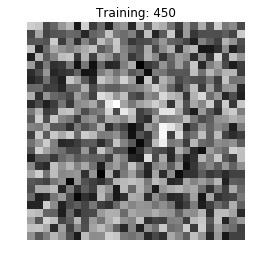

In [45]:
# Which hidden node?
hid_node = 450

# Plot it
# we're recylcing the function from before, so the title will still say
# 'Training', but ignore that.
plot_handwritten_digit(model.get_weights()[0][:,hid_node-1].reshape((28, 28)), hid_node)

In [46]:
model.get_weights()[0][:,1].shape

(784,)

## Deeper Network with Dropout

Let's also try a deeper neural network with more layers.  Specifically, one input layer, two fully connected hidden layers using sigmoid activation, and one output layer using softmax activation.

### `keras`

In [47]:
# Tell keras we want to create a sequential (feed-forward network) model, in which one
# layer follows the next
deeper_model = Sequential()

# Create the input layer and the hidden layer of the network
# 'Dense' indicates that we want all inputs to connect to every node in the hidden layer
# 'input_shape' tells the hidden layer the dimension of the input to expect, which is determined
#    by our data (the number of predictors in our data set = 784 pixels per image)
# 'NUM_HIDDEN_UNITS' (which we defined above) tells keras how many nodes are the hidden layer connected
#    to the input layer
# 'activation' specifies how values from the input node should be processed by hidden nodes.
deeper_model.add(Dense(NUM_HIDDEN_UNITS, input_shape=(784,), activation='sigmoid', init='uniform'))

# Next, implement dropout in the first layer, with 50% of the input nodes being 
# dropped for each iteration.
deeper_model.add(Dropout(0.5))

# Next, create a second hidden layer with sigmoid activation, and
# implement drop out.  Keras will look at the most layer we just created
# to figure out how many inputs to expect.
deeper_model.add(Dense(NUM_HIDDEN_UNITS, activation='sigmoid', init='uniform'))
deeper_model.add(Dropout(0.5))

# Next, we'll create the output layer.
deeper_model.add(Dense(10, activation='softmax', init='uniform'))

# Next, we specify the properties of our optimizer.
# We'll be using stochastic gradient descent with momentum, along with 
# the crossentropy cost function.
# Note: We're using a larger learning rate than in the single-layer network, and
# and no decay.  I arrived at these settings through tuning, but intuitively this is 
# a more complicated function to optimize (given the additional layer)
# and since I don't want to run over a huge number of epochs, I'm asking keras
# to learn faster.  This may not always work in practice.
sgd = SGD(lr=4.*LEARNING_RATE, decay=0., momentum=MOMENTUM, nesterov=True)
deeper_model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Summarize the model setup
deeper_model.summary()

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_shape=(784,), activation="sigmoid", kernel_initializer="uniform")`
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="sigmoid", kernel_initializer="uniform")`
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Vectorize the response once again, and train the network.
Y_train = np_utils.to_categorical(y_train, 10)
deeper_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS)

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
50000/50000 [==============================] - 4s - loss: 2.3208     
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 2.1674     
Epoch 3/10
50000/50000 [==============================] - 4s - loss: 1.5823     
Epoch 4/10
50000/50000 [==============================] - 4s - loss: 1.1307     
Epoch 5/10
50000/50000 [==============================] - 5s - loss: 0.9192     
Epoch 6/10
50000/50000 [==============================] - 5s - loss: 0.7876     
Epoch 7/10
50000/50000 [==============================] - 5s - loss: 0.6991     
Epoch 8/10
50000/50000 [==============================] - 4s - loss: 0.6347     
Epoch 9/10
50000/50000 [==============================] - 5s - loss: 0.5944     - ETA: 0s - loss: 0.
Epoch 10/10
50000/50000 [==============================] - 4s - loss: 0.5596     


In [50]:
Y_test_deeper = deeper_model.predict_classes(X_test)
#test_preds = np_utils.categorical_probas_to_classes(Y_test_keras)
print(classification_report(Y_test_deeper, test_preds))
print(accuracy_score(Y_test_deeper, test_preds))

 9568/10000 [===========================>..] - ETA: 0s             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1028
          1       0.99      0.96      0.97      1212
          2       0.97      0.94      0.95      1005
          3       0.92      0.96      0.94      1021
          4       0.91      0.93      0.92      1061
          5       0.94      0.88      0.91       863
          6       0.97      0.93      0.95      1001
          7       0.94      0.97      0.95      1009
          8       0.89      0.98      0.93       832
          9       0.91      0.88      0.89       968

avg / total       0.94      0.94      0.94     10000

0.942


## Tensorflow

Tensorflow is an open-source package provided by Google specifically designed for deep learning. In terms of what we've done so far in this notebook, it's comparable to theano in that it's a computational backend that can be paired with keras.  However, it can also be used directly (as can theano actually) to specify, train, and evaluate neural networks.  

The basic idea behind tensorflow is to describe a network as a  'map' in which nodes correspond to computations (e.g., apply softmax function or sigmoid function), and the edges between nodes correspond to the flow of *tensors* (or multi-dimensional arrays) as they get processed via successive computations. Essentially, the tensors "flow" through the map, getting modified along the way.  

Like theano, one key function of tensorflow is its ability to automatically calculate the derivatives required by gradient descent.  It figures out how all the parameters feed into the loss function, and calculates derivatives accordingly.

In addition, tensorflow has many advanced features that we won't discuss.  For instance, it is designed to work well with GPU's, which have been found to be very good at performing the computations required by neural networks.  It can also be used for distributed processing, or even on smart phones.

Instructions for installing tensorflow can be found here: https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html.  If you want the simplest possible install, I'd stick with the 'CPU Only' approach, which avoids having to setup additional packages required for GPU processing.

Also, there now exists a tensorflow wrapper in R, which let's you use tensorflow without leaving R. I have not tried it, but if you do, let me know what you think.
https://rstudio.github.io/tensorflow/

Note that the R wrapper warns against installing tensorflow using anaconda, which is unfortunate.  I used the conda installation for use in Python, which worked fine.

We'll now do the digit classification problem in tensorflow.  This example is heavily based on Google's own example: https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/mnist/mnist_softmax.py

### Digit Classification

In [51]:
# Let's import tensorflow
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [52]:
# Pull down the data in a tensforflow-friendly format
mnist_tf = input_data.read_data_sets("MNIST_data/",one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Our data again consists of 28x28 pixel images, for 784 total pixes per image.  We therefore create a tensor flow *placeholder* to reprsent the input layer in our network.  We won't actually provide data yet -we're just telling tensorflow to expect data of a certain shape.

In [53]:
x = tf.placeholder(tf.float32, [None,784])

The ```float32``` tells tensorflow the type of data that will be stored in ```x```.  The ```[None,784]``` tells tensorflow to expect data with some (unspecified) number of rows, and 784 columns.

Next, we need to add objects to our tensorflow map that correspond to the weights and biases of our neural network.  Specifically, we create tensorflow ```variables```, which can be updated as tensforflow performs gradient descent.

In [54]:
# Weights and biases used to map inputs to hidden layer
W = tf.Variable(tf.zeros([784,500]))
b = tf.Variable(tf.zeros([500]))

# Calculation of hidden layer using sigmoid activation
h = tf.sigmoid(tf.matmul(x,W)+b)

# Weights and biases used to map hidden layer to output layer
hW = tf.Variable(tf.zeros([500,10]))
hb = tf.Variable(tf.zeros([10]))

# Calculation to map hidden layer to output layer
# Note: We'll apply softmax implicitly in the cost function
y = tf.matmul(h,hW)+hb

# Placeholder for the training response data
y_ = tf.placeholder(tf.float32,[None,10])

Next, we specify our objective function, and how we'd like to update our parameters -in our case, via gradient descent

In [63]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,labels=y_))
train_step = tf.train.GradientDescentOptimizer(0.9).minimize(cross_entropy)
print("done")  # this calculation can take a little while
#train_step = tf.train.MomentumOptimizer(learning_rate=0.5,momentum=0.9).minimize(cross_entropy)

done


Finally, we initialize all of the variables in the tensorflow map, start a session (tensorflow operations need to take place within a session), then iterate using the gradient descent algorithm in order to adjust the weights and minimize cost.

In [65]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = mnist_tf.train.next_batch(600)
    sess.run(train_step,feed_dict={x: batch_xs, y_: batch_ys})
    if i%100==0:
        print("status update: ", i)

0
100
200
300
400
500
600
700
800
900


In [66]:
# Lastly, we calculate accuracy of our fitted neural network
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy,feed_dict={x: mnist_tf.test.images, y_: mnist_tf.test.labels}))

0.3129


Definitely bad, but I did no tuning.

In [ ]:
# Close the tensorflow session
sess.close()

## Unsurpervised Feature Learning with a Restricted Boltzmann Machine (RBM)

Here, we'll do unsupervised feature learning, or dimensionality reduction.  This can be done with an autoencoder or a restricted boltzmann machine (RBM).  Without getting into too many of the details, both an autoencoder and an RBM have an input and a single hidden layer of reduced dimensionality.  The hidden layer is trained so that it can take the input and reconstruct it as accurately as possible, but with a smaller set of hidden nodes than input nodes.  Luckily for us, scikit-learn has an RBM class.

In [67]:
digits = datasets.load_digits()
X_train = np.asarray(digits.data, 'float32')
y_train = digits.target

Let's take our training set and center it so that the features are all between 0 and 1:

In [68]:
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)  # 0-1 scaling

Let's take a random 10k observations to train on:

In [69]:
N_EXAMPLES = 10000
X_train_rbm, X_test_rbm, y_train_rbm, y_test_rbm = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

X_train_rbm = X_train_rbm[0:N_EXAMPLES]
y_train_rbm = y_train_rbm[0:N_EXAMPLES]

The RBM needs a learning rate and a number of iterations to train for.  The parameter `n_components` tells it how many hidden nodes to use.  It's the dimensionality of the reduced dimension space (like PCA or t-SNE).

In [70]:
rbm = BernoulliRBM(learning_rate=0.05, n_iter=20, n_components=200, random_state=0, verbose=True)

We fit the RBM like so:

In [71]:
rbm.fit(X_train_rbm)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -27.16, time = 0.05s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -26.23, time = 0.08s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -25.94, time = 0.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -26.19, time = 0.04s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -25.71, time = 0.05s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -24.81, time = 0.06s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -24.67, time = 0.06s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -24.64, time = 0.05s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -22.60, time = 0.05s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -21.81, time = 0.09s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -21.89, time = 0.04s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -21.87, time = 0.04s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -21.52, time = 0.05s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -22.05, time = 0.07s
[BernoulliRBM] Iteration 15, 

BernoulliRBM(batch_size=10, learning_rate=0.05, n_components=200, n_iter=20,
       random_state=0, verbose=True)

In [72]:
rbm.components_.shape

(200, 64)

To see what kinds of features the hidden nodes are learning, we can plot each node as a 28 by 28 pixel image where the darkness is how large the weight is connecting the hidden node to the corresponding input node:

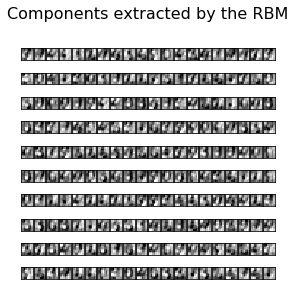

In [74]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 20, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

plt.suptitle('Components extracted by the RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

Let's look in more detail at some of the individual hidden nodes:

In [77]:
def plot_rbm_component(comp_num):
    plt.figure(figsize=(4.2, 4))

    comp = rbm.components_[comp_num]
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

    plt.show()

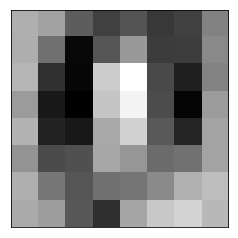

In [78]:
# 60, 80, 90, 120
plot_rbm_component(120)

Let's see how a logistic regression trained using just the raw pixel values does:

In [83]:
N_LOGIT_TRAIN_EXAMPLES = 4000

pixel_logit = LogisticRegression()
pixel_logit.fit(X_train_rbm[0:N_LOGIT_TRAIN_EXAMPLES], y_train_rbm[0:N_LOGIT_TRAIN_EXAMPLES])

# score it on the same test set we used above
print(classification_report(y_test_rbm, pixel_logit.predict(X_test_rbm)))
print(accuracy_score(y_test_rbm, pixel_logit.predict(X_test_rbm)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        89
          1       0.94      0.94      0.94        90
          2       0.98      0.98      0.98        92
          3       0.97      0.94      0.95        93
          4       0.97      0.97      0.97        76
          5       0.94      0.95      0.94       108
          6       0.96      0.98      0.97        89
          7       0.95      1.00      0.97        78
          8       0.93      0.86      0.89        92
          9       0.90      0.92      0.91        92

avg / total       0.95      0.95      0.95       899

0.953281423804


Now let's see how it does with the features learned by the RBM:

In [84]:
rbm_logit = LogisticRegression()
rbm_features_train = rbm.transform(X_train_rbm[0:N_LOGIT_TRAIN_EXAMPLES]) 
rbm_logit.fit(rbm_features_train, y_train_rbm[0:N_LOGIT_TRAIN_EXAMPLES])

rbm_features_test = rbm.transform(X_test_rbm) 
print(classification_report(y_test_rbm, rbm_logit.predict(rbm_features_test)))
print(accuracy_score(y_test_rbm, rbm_logit.predict(rbm_features_test)))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96        89
          1       0.72      0.70      0.71        90
          2       0.77      0.82      0.79        92
          3       0.78      0.73      0.76        93
          4       0.95      0.93      0.94        76
          5       0.92      0.67      0.77       108
          6       0.92      0.93      0.93        89
          7       0.72      0.91      0.80        78
          8       0.79      0.63      0.70        92
          9       0.61      0.77      0.68        92

avg / total       0.81      0.80      0.80       899

0.800889877642


We can also take the hidden features learned by the RBM, and train a new RBM on them:

In [85]:
rbm_2 = BernoulliRBM(learning_rate=0.05, n_iter=50, n_components=150, random_state=0, verbose=True)
rbm_2.fit(rbm_features_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -117.73, time = 0.07s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -118.51, time = 0.10s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -118.87, time = 0.07s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -118.26, time = 0.07s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -118.17, time = 0.12s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -117.87, time = 0.06s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -118.00, time = 0.09s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -118.30, time = 0.08s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -117.53, time = 0.06s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -117.40, time = 0.06s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -117.15, time = 0.09s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -116.43, time = 0.06s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -115.77, time = 0.07s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -115.57, time = 0.06s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.05, n_components=150, n_iter=50,
       random_state=0, verbose=True)

In [86]:
rbm_logit_2 = LogisticRegression()
rbm_features_train_2 = rbm_2.transform(rbm_features_train) 
rbm_logit_2.fit(rbm_features_train_2, y_train_rbm[0:N_LOGIT_TRAIN_EXAMPLES])

rbm_features_test_2 = rbm_2.transform(rbm_features_test) 
print(classification_report(y_test_rbm, rbm_logit_2.predict(rbm_features_test_2)))
print(accuracy_score(y_test_rbm, rbm_logit_2.predict(rbm_features_test_2)))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94        89
          1       0.55      0.43      0.48        90
          2       0.60      0.85      0.70        92
          3       0.79      0.63      0.70        93
          4       0.92      0.95      0.94        76
          5       0.62      0.19      0.30       108
          6       0.98      0.92      0.95        89
          7       0.40      0.91      0.56        78
          8       0.66      0.23      0.34        92
          9       0.54      0.71      0.61        92

avg / total       0.69      0.66      0.64       899

0.661846496107
